In [2]:
import numpy as np
import pandas as pd
from numpy import sqrt
import matplotlib.pyplot as plt
import timesynth as ts
from sklearn.cluster import DBSCAN
from pmdarima import model_selection

In [3]:
def gen_time_series(n,num_points,outlier=True):
    time_series = pd.DataFrame([])
    time_sampler = ts.TimeSampler(stop_time=20)
    # Sampling irregular time samples
    irregular_time_samples = time_sampler.sample_irregular_time(num_points=num_points, keep_percentage=50)
    # Initializing Sinusoidal signal
    sinusoid = ts.signals.Sinusoidal(frequency=0.25)
    for i in range(n):
            # Initializing Gaussian noise
            white_noise = ts.noise.GaussianNoise(std=0.3)
            # Initializing TimeSeries class with the signal
            timeseries = ts.TimeSeries(sinusoid, noise_generator=white_noise)
            samples, signals, errors = timeseries.sample(irregular_time_samples) 
            time_series[str(i)] = samples
    
    if (outlier == True):
        white_noise = ts.noise.GaussianNoise(std=0.7)
        timeseries = ts.TimeSeries(sinusoid, noise_generator=white_noise)
        outlier_samples, outlier_signals, outlier_errors = timeseries.sample(irregular_time_samples)
        time_series["outlier"] = outlier_samples
       
    else:
        time_series
    
    return time_series

**Parameters**
- epsfloat, default=0.5

The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose appropriately for your data set and distance function.

- min_samplesint, default=5

The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.

- metricstring, or callable, default=’euclidean’

The metric to use when calculating distance between instances in a feature array. If metric is a string or callable, it must be one of the options allowed by sklearn.metrics.pairwise_distances for its metric parameter. If metric is “precomputed”, X is assumed to be a distance matrix and must be square. X may be a Glossary, in which case only “nonzero” elements may be considered neighbors for DBSCAN.

- metric_paramsdict, default=None

Additional keyword arguments for the metric function.

- algorithm{‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’

The algorithm to be used by the NearestNeighbors module to compute pointwise distances and find nearest neighbors. See NearestNeighbors module documentation for details.

- leaf_sizeint, default=30

Leaf size passed to BallTree or cKDTree. This can affect the speed of the construction and query, as well as the memory required to store the tree. The optimal value depends on the nature of the problem.

- pfloat, default=None

The power of the Minkowski metric to be used to calculate distance between points.

- n_jobsint or None, default=None

The number of parallel jobs to run. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. See Glossary for more details.

In [19]:
test = gen_time_series(10,500,outlier=True)
test.head()

,0,1,2,3,4,5,6,7,8,9,outlier
0,0.728815,0.174845,0.401676,0.418373,0.474304,0.153375,0.541289,-0.129052,-0.153260,0.347924,-0.128414
1,0.373184,0.074828,0.527649,0.914098,0.186814,0.798834,0.293254,0.431961,0.204011,0.768193,0.405711
2,0.376329,0.599517,0.033554,0.768217,0.617440,0.544672,0.506350,0.925683,0.015581,0.189389,1.691549
3,0.549139,-0.054688,0.789697,0.957496,0.542915,1.013051,0.165562,0.070301,0.373655,0.350108,0.297662
4,1.286076,0.464706,1.012641,0.537066,0.036077,0.487752,0.398601,0.633441,0.805642,0.828572,-0.056663


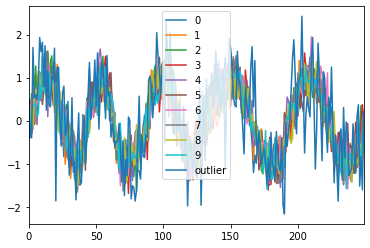

In [5]:
test.plot()

In [32]:
base = datetime.datetime.today()
date_list = [base - datetime.timedelta(days=x) for x in range(500)]

In [23]:
import datetime
s = pd.Series(date_list, name = 'TimeStamp')
test.insert(0, 'TimeStamp', s)
test = test.set_index("TimeStamp")
test.head()

,0,1,2,3,4,5,6,7,8,9,outlier
TimeStamp,,,,,,,,,,,
2020-05-07 07:37:36.801561,0.728815,0.174845,0.401676,0.418373,0.474304,0.153375,0.541289,-0.129052,-0.153260,0.347924,-0.128414
2020-05-06 07:37:36.801561,0.373184,0.074828,0.527649,0.914098,0.186814,0.798834,0.293254,0.431961,0.204011,0.768193,0.405711
2020-05-05 07:37:36.801561,0.376329,0.599517,0.033554,0.768217,0.617440,0.544672,0.506350,0.925683,0.015581,0.189389,1.691549
2020-05-04 07:37:36.801561,0.549139,-0.054688,0.789697,0.957496,0.542915,1.013051,0.165562,0.070301,0.373655,0.350108,0.297662
2020-05-03 07:37:36.801561,1.286076,0.464706,1.012641,0.537066,0.036077,0.487752,0.398601,0.633441,0.805642,0.828572,-0.056663


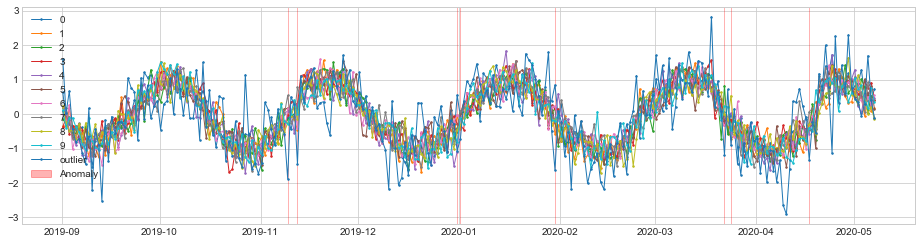

In [31]:
from adtk.detector import MinClusterDetector
from sklearn.cluster import KMeans
from adtk.visualization import plot
min_cluster_detector = MinClusterDetector(KMeans(n_clusters=12))
anomalies = min_cluster_detector.fit_detect(test)
plot(test, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

In [7]:
# >>> from sklearn.cluster import DBSCAN
# >>> import numpy as np
# >>> X = np.array([[1, 2], [2, 2], [2, 3],
# ...               [8, 7], [8, 8], [25, 80]])
# clustering = DBSCAN(eps=3, min_samples=2).fit(X)
# clustering.labels_
# array([ 0,  0,  0,  1,  1, -1])
# >>> clustering
# DBSCAN(eps=3, min_samples=2)

# train, test = model_selection.train_test_split(test, train_size=0.8)
# clustering = DBSCAN().fit(train)